In [1]:
# check if you have dataset 
# if not add dataset
# Turn on you GPU

In [2]:
# import all library required
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl

# style your matplotlib
mpl.style.use("seaborn-darkgrid")
# run this block

In [3]:
from tqdm import tqdm # show progress bar of for loop


In [4]:
# list of files in train folder
files=os.listdir("../input/mma-facial-expression/MMAFEDB/train/")
files


['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

In [5]:
# restart our notebook and run from top to bottom

In [6]:
# now create image and label array
image_array=[]  # it's a list later i will convert it to array
label_array=[]
path="../input/mma-facial-expression/MMAFEDB/train/"
# loop through each sub-folder in train
for i in range(len(files)):
    # files in sub-folder
    file_sub=os.listdir(path+files[i])

   # print(len(file_sub))
    # loop through each files
    
    # for neutral and happy dataset we will use only 18000 image
    if(files[i]=="neutral" or files[i]=="happy"):
        for k in tqdm(range(18000)):
            # read image
            img=cv2.imread(path+files[i]+"/"+file_sub[k])
            # convert image from BGR to RGB
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # append image_array with img
            image_array.append(img)
            label_array.append(i)
            # i is interger from 0-6
            # run this block
    else:
        # for other all 
        for k in tqdm(range(len(file_sub))):
            # read image
            img=cv2.imread(path+files[i]+"/"+file_sub[k])
            # convert image from BGR to RGB
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # append image_array with img
            image_array.append(img)
            label_array.append(i)
            # i is interger from 0-6
            # run this block

100%|██████████| 18000/18000 [02:58<00:00, 100.86it/s]


In [7]:
a,b=np.unique(label_array,return_counts="True")
a

array([0, 1, 2, 3, 4, 5, 6])

In [8]:
b
# due to low ram memory we have to reduce our training dataset
# we will reduce 29384,28592 to 18000
# this will solve low memory issue

array([ 8113,  4859,  6566, 18000, 12223,  3231, 18000])

In [9]:
# check you code

In [10]:
# now use this to free some ram memory
import gc
gc.collect()

232

In [11]:
# now divide image_array by 255.0
# this wil scale image pixel from 0-255 to 0-1
image_array=np.array(image_array)/255.0
# convert label list to array
label_array=np.array(label_array)
# run this block

In [12]:
#image_array[0]
#label_array


In [13]:
# now define label_to_text 
#['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
label_to_text={0:"surprise",1:"fear",2:"angry",3:"neutral",4:"sad",5:"disgust",6:"happy"}

In [14]:
# this dic can convert label to text_label
# example
label_to_text[1]

'fear'

In [15]:
# now shuffle and split image and labels into train and test

In [16]:
from sklearn.model_selection import train_test_split
image_array,X_test,Y_train,Y_test=train_test_split(image_array,label_array,test_size=0.1)
# you can change test size 
# we are using 10% for validation

#now before running this block change X_train to image_array to save ram memory
gc.collect()

0

In [17]:
# if you want to see image and label
# define dic for converting label to test_label
#['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
label_to_text={0:"surprise",1:"fear",2:"angry",3:"neutral",4:"sad",5:"disgust",6:"happy"}

In [18]:
label_to_text[2]

'angry'

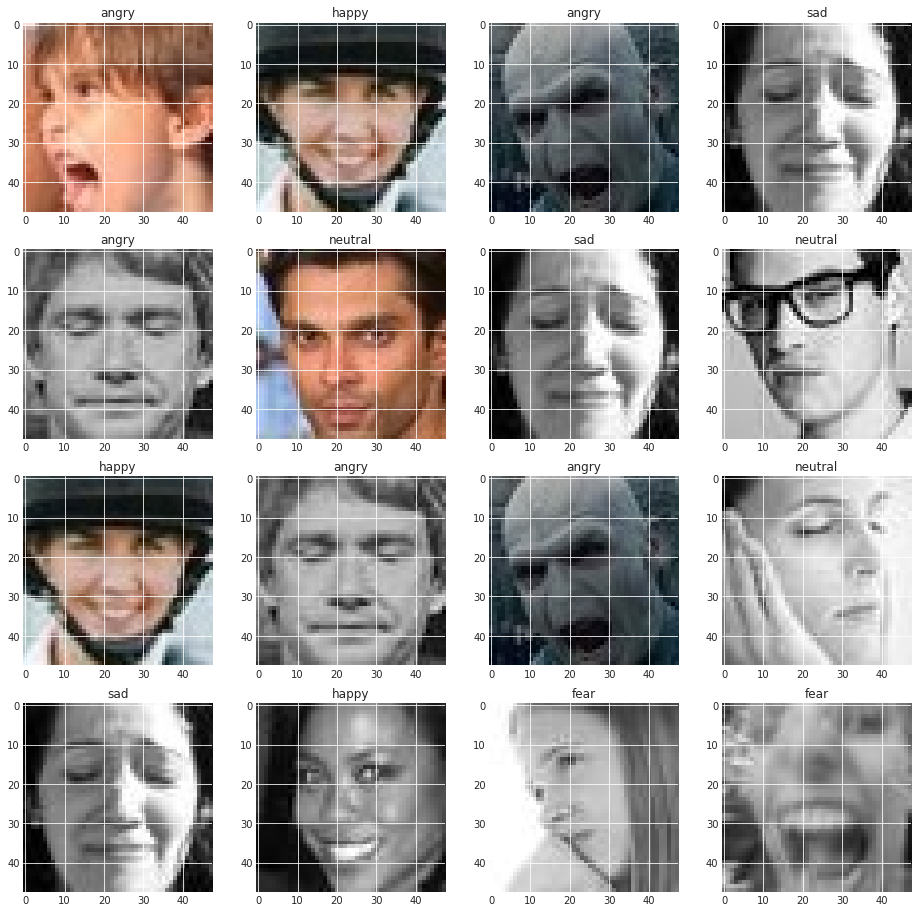

In [19]:
# define a function 
def show_examples(image,label,idx):
    # create 4x4 figure
    fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(16,16))
    # loop through each figure
    for idx_f,ax in zip(idx,axes.ravel()):
        # add image to figure
        ax.imshow(image[idx_f].squeeze(),cmap="gray")
        # add title to each figure
        ax.set_title(label_to_text[label[idx_f]])
    plt.show()
idx=np.random.choice(16,16)
show_examples(image_array,Y_train,idx)

In [20]:
# now we will start with our model
# import all library required for model
from keras import layers,callbacks,utils,applications,optimizers
from keras.models import Sequential,Model,load_model
# run this block

In [21]:
model=Sequential()
# I will use MobileNetV2 as an pretrained model 
pretrained_model=applications.MobileNetV2(input_shape=(48,48,3),include_top=False,
                                         weights="imagenet")
# you can use other pretrained model to increase accuracy or increase frame rate
# change all non-trainable layer to trainable
pretrained_model.trainable=True
# add pretrained_model to model
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
# add dropout to increase accuracy by not overfitting
model.add(layers.Dropout(0.3))
# add dense layer as final output
model.add(layers.Dense(1))
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [22]:
# you can add more layer to increase accuracy

In [23]:
from tensorflow.keras.optimizers import Adam

In [24]:
#compile model

model.compile(optimizer=Adam(0.0001),loss="mean_squared_error",metrics=["mae"])
# run
# starting learning rate is 1e-3
# you can change optimizer, loss function, metrics for better result

In [25]:
# create a model checkpoint to save model
ckp_path="trained_model/model"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,
                                                   monitor="val_mae",
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   mode="auto")
# this checkpoint save model when val_mae is lower then best val_mae
#run
                                                    

In [26]:
# now we will define learning rate reducer 
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(factor=0.9,
                                              monitor="val_mae",
                                              mode="auto",
                                              cooldown=0,
                                              patience=5,
                                              verbose=1,
                                              min_lr=1e-6)
# this will decrease learning rate when val_mae does't decrease durning last 5 epoch
# verbose is use to show val_mae every epoch


In [27]:
EPOCHS=300
BATCH_SIZE=64
# start training
history=model.fit(image_array,Y_train,
                 validation_data=(X_test,Y_test),
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[model_checkpoint,reduce_lr])
#run

Epoch 1/300
999/999 [==============================] - 34s 26ms/step - loss: 5.4372 - mae: 1.8519 - val_loss: 38.6322 - val_mae: 5.8628
Epoch 2/300
999/999 [==============================] - 23s 23ms/step - loss: 2.8571 - mae: 1.3510 - val_loss: 5.2014 - val_mae: 1.8531
Epoch 3/300
999/999 [==============================] - 24s 24ms/step - loss: 2.3893 - mae: 1.2243 - val_loss: 3.8229 - val_mae: 1.5640
Epoch 4/300
999/999 [==============================] - 25s 25ms/step - loss: 2.1509 - mae: 1.1510 - val_loss: 3.0387 - val_mae: 1.3757
Epoch 5/300
999/999 [==============================] - 24s 24ms/step - loss: 1.9227 - mae: 1.0793 - val_loss: 2.6094 - val_mae: 1.2482
Epoch 6/300
999/999 [==============================] - 24s 24ms/step - loss: 1.7771 - mae: 1.0309 - val_loss: 2.2847 - val_mae: 1.1685
Epoch 7/300
999/999 [==============================] - 24s 24ms/step - loss: 1.5409 - mae: 0.9513 - val_loss: 2.3038 - val_mae: 1.1538
Epoch 8/300
999/999 [==============================] -

In [28]:
# you can increase more data as 2 gb ram memory is left
# this will take time

In [29]:
# after training is finished 
# load best model
model.load_weights(ckp_path)

In [30]:
# if you want to see result
prediction_val=model.predict(X_test,batch_size=BATCH_SIZE)


In [31]:
# remember X_test is use for validation and for testing 
# to get beffer result use different data for validation and testing

In [32]:
# prediction value 
prediction_val[:10]

array([[3.784317 ],
       [4.1156797],
       [3.1610758],
       [2.7373793],
       [2.9713798],
       [5.982994 ],
       [3.259957 ],
       [4.4208355],
       [1.860516 ],
       [3.2986178]], dtype=float32)

In [33]:
# original value
Y_test[:10]

array([4, 4, 3, 3, 3, 6, 3, 3, 2, 4])

In [34]:
# now convert model to tensorflow lite model 
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

#save model 
with open("model.tflite","wb") as f:
    f.write(tflite_model)

In [35]:
# save this version

In [36]:
#